# Cross-Sectional Models: Predicting Baseline Diagnosis

In [75]:
#!pip install seaborn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [97]:
adni_df = pd.read_csv("/Users/Nathan/Desktop/AC209/ADNI/ADNImerge/ADNIMERGE.csv")

In [98]:
# "Dementia" -> "AD": 
# With the exception of 6 cases, all observations for which DX=="Dementia" had baseline diagnoses of "AD",
# suggesting that Dementia can be recoded to AD
erronious_obs = adni_df[(adni_df.DX == 'Dementia') & (adni_df.VISCODE == 'bl') & (adni_df.DX_bl != 'AD')]
adni_df = adni_df.drop(erronious_obs.index)
adni_df.loc[adni_df.DX == 'Dementia', 'DX'] = 'AD'

# collapse DX_bl groups: "EMCI"/"LMCI" --> "MCI"; "SMC" --> "CN"
adni_df.loc[adni_df['DX_bl'].isin(['EMCI', 'LMCI']), 'DX_bl'] = 'MCI'
adni_df.loc[adni_df['DX_bl'] == 'SMC', 'DX_bl'] = 'CN'

erronious_obs_AD_MCI = adni_df[(adni_df['DX_bl'] == 'AD') & (adni_df['DX'] == 'MCI') & (adni_df.VISCODE == 'bl')]
erronious_obs_MCI_CN = adni_df[(adni_df['DX_bl'] == 'MCI') & (adni_df['DX'] == 'CN') & (adni_df.VISCODE == 'bl')]
erronious_obs = pd.concat([erronious_obs_AD_MCI, erronious_obs_MCI_CN, erronious_obs])
adni_df = adni_df.drop(erronious_obs_AD_MCI.index)
adni_df = adni_df.drop(erronious_obs_MCI_CN.index)

In [99]:
adni1_df = adni_df[adni_df['ORIGPROT'] == 'ADNI1'].copy()
adni2_df = adni_df[adni_df['ORIGPROT'] == 'ADNI2'].copy()
adni3_df = adni_df[adni_df['ORIGPROT'] == 'ADNI3'].copy()
adnigo_df = adni_df[adni_df['ORIGPROT'] == 'ADNIGO'].copy()

## MODEL 1 - Cross-sectional prediction of baseline diagnoses

We began by developing a basic multiclass logistic regression model to predict baseline diagnosis from data available at that initial visit to get a rough understanding of the strength of the available predictors, as well as to compare how well they perform in predicting cross-sectional diagnosis versus longitudinal change in diagnosis. 

The logistic regression classifier achieves a training score of 81.1% and a test score of 76.4% (based on a 25% train-test split stratified by diagnosis). The confusion matrices for the training and test sets show that the model does a good job discerning between the three classes, without always defaulting to -- though clearly biased toward -- the dominant group. (48.8% of observations were classified as MCI, 28.2% as CN, and 23.0% as AD).

In [100]:
df = adni1_df[adni1_df['M'] == 0] # only keeping the baseline measures

# dealing with the '<' and '>' in abeta and tau and ptau
genes = ['TAU', 'ABETA', 'PTAU']
for val in genes:
    all_vals = df[val].values
    df = df.drop(val, axis=1)
    df[val] = [float(str(x).replace('<','').replace('>','')) for x in all_vals]

# drop collinear, unrelated or missing variables
collinear = ['DX_bl', 'M', 'VISCODE', 'update_stamp', 'Month']
unrelated = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION', 'IMAGEUID', 'FLDSTRENG', 'EXAMDATE']
baselines = []
nulls = dict(df.isna().sum().sort_values())
null_cols = []

# filling out null_cols and baselines
for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baselines.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baselines.append(i)
        
df = df.drop(collinear + unrelated + baselines + null_cols, axis=1)

# dealing with categorical variables
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categoricals = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummies = pd.get_dummies(df[categoricals])
df = pd.concat([df, dummies], axis=1)

# more informative names
df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})

# drop categoricals
df = df.drop(categoricals, axis=1)

# dropping rows that are missing the response variable
df = df.dropna(subset=['DX'])

# making the 'DX' variable numeric
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'AD': 3})

In [101]:
# imputation through kNN with 5 neighbors

null_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_nulls = null_df[null_df['Nulls'] > 0].to_dict()['Nulls']
nulls = new_nulls.keys()
not_nulls = df.columns.difference(nulls).values
ind_dict = {}

# filling it with a weird value for now
weird_value = -247
df = df.fillna(weird_value)

for n, col in enumerate(nulls):
    # Training set: all the rows for which the entry in the corresponding column does not contain a '0'
    pseudo_train = df[df[col] != weird_value]
    pseudo_x = pseudo_train[pseudo_train.columns.difference([col, 'DX'])]
    pseudo_y = pseudo_train[col]
    
    # Doing the same for the "test" set
    pseudo_test = df[df[col] == weird_value]
    pseudo_x_tes = pseudo_test[pseudo_test.columns.difference([col, 'DX'])]
    pseudo_y_tes = pseudo_test[col]
    
    # Fitting a kNN model with N=5
    chosen_model = KNeighborsRegressor(n_neighbors=5).fit(pseudo_x, pseudo_y)
    
    # Saving the indices into a dictionary
    ind = df[df[col] == weird_value][col].index.values
    ind_dict[col] = chosen_model.predict(pseudo_x_tes)
    
# doing the actual imputation
for col in nulls:
    ind = df[df[col] == weird_value][col].index.values
    df.loc[ind, col] = ind_dict[col]

In [102]:
# categorizing variables

# THESE WORK FOR ADNI_1
demographic = ['AGE', 'PTGENDER_Female', 'PTEDUCAT', 
               'PTETHCAT_Hisp/Latino', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 
               'PTRACCAT_Am Indian/Alaskan', 'PTRACCAT_Asian', 'PTRACCAT_Black', 
               'PTRACCAT_More than one', 'PTRACCAT_White', 
               'PTMARRY_Divorced', 'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed']

ravlt = ['RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting']
adas = ['ADAS11', 'ADAS13', 'ADASQ4']
exams = ['MMSE', 'CDRSB', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB', 'LDELTOTAL']
genetic = ['APOE4','TAU', 'ABETA', 'PTAU', 'FDG']
brain = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
adni1 = ['DIGITSCOR']

# USE THE FOLLOWING ONLY FOR ADNI_2!
adni2 = ['AV45', 'MOCA', 
         'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 
         'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPTotal', 
         'PTRACCAT_Unknown', 'PTRACCAT_Hawaiian/Other PI']

response = ['DX']


# Train-test split
y = df['DX']
X = df[df.columns.difference(['DX'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=209, stratify=y)

In [103]:
# Using logistic regression
baseline_logreg = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)
#baseline_logreg.score(X_train, y_train), baseline_logreg.score(X_test, y_test)

(0.8111658456486043, 0.7635467980295566)

In [105]:
# Code credit: sklearn example
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0, fontsize=13)
    ax.set_yticklabels(classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    ax.set_title(title, fontsize=18, fontweight='heavy')
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.grid('off')

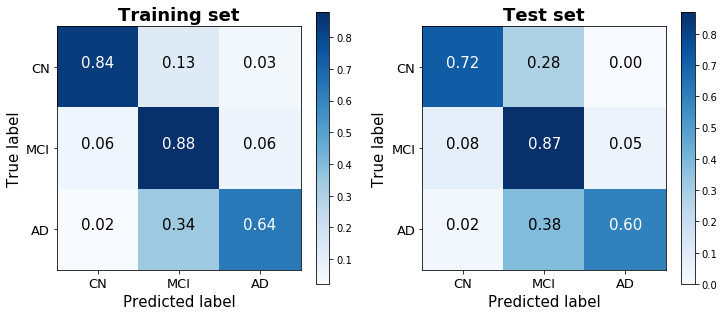

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train, baseline_logreg.predict(X_train))
cnf_matrix_ts = confusion_matrix(y_test, baseline_logreg.predict(X_test))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['CN','MCI','AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['CN','MCI','AD'], normalize=True, title='Test set')

## MODEL 2 - Cross-sectional prediction of baseline diagnoses only based on MMSE and CDRSB

Rather than predicting baseline diagnosis with all available predictors, we also sought to determine the predictive accuracy of two cognitive tests -- the MMSE (Mini-Mental State Examination) and CDRSB (Clinical Dementia Rating Scaled Response) -- that our EDA suggested correlate highly with baseline diagnosis. Importantly, cognitive tests such as the MMSE and CDRSB are very low-cost to administer, and are therefore the first method typically used to identify cognitive decline among patients. This model therefore serves to measure the misdiagnosis rate liable to occur by using these low-cost methods, and to identify any systematic biases that they may suffer from.

This logistic model was therefore purposefully rudimentary, performed without any regularization or boosting. Nevertheless, it achieves a strikingly high training score of 92.6% and a test score of 91.6%. A confusion matrix of its predictions demonstrates the ease with which the three classes are distinguished using just two predictors. Noteably, this parsimonious model performed significantly better than the model with all readily-available predictors that was considered above, and generated predictions that were less biased toward the dominant MCI class than the previous model as well. 
 
The decision boundaries of this model are illustrated below (using jitter to illustrate density of points belonging to the CN class), and show that there is clear separability between the three classes based on MMSE and CDRSB scores.

In [107]:
# Turns out MMSE and CDRSB are all that's needed to do a great job with predicting DX
X_train2 = X_train[['MMSE', 'CDRSB']]
X_test2 = X_test[['MMSE', 'CDRSB']]
baseline_logreg = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train2, y_train)
#baseline_logreg.score(X_train2, y_train), baseline_logreg.score(X_test2, y_test)

(0.9261083743842364, 0.916256157635468)

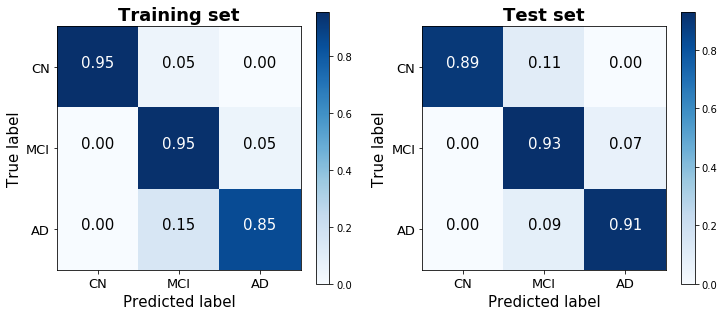

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train, baseline_logreg.predict(X_train))
cnf_matrix_ts = confusion_matrix(y_test, baseline_logreg.predict(X_test))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['CN','MCI','AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['CN','MCI','AD'], normalize=True, title='Test set')

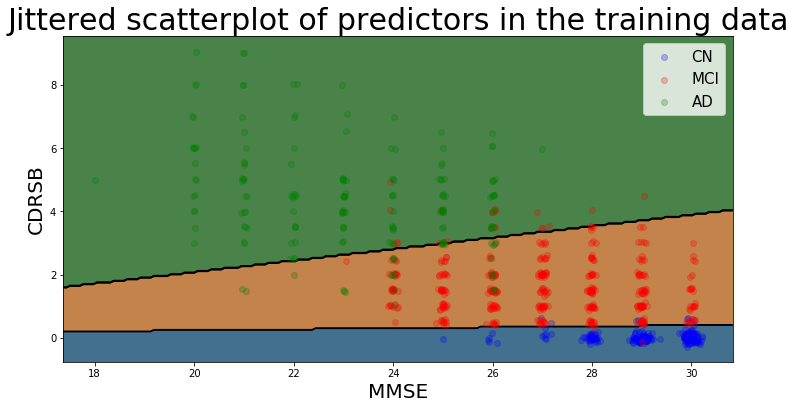

In [112]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
 

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def plot_points(x,y,
               title='Jittered scatterplot of predictors in the training data',
               ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(x[y == 1].iloc[:,0] + np.random.normal(0, 0.1, x[y == 1].shape[0]), 
               x[y == 1].iloc[:,1] + np.random.normal(0, 0.1, x[y == 1].shape[0]),
               color='blue', alpha=0.25,label = 'CN')
    ax.scatter(x[y == 2].iloc[:,0] + np.random.normal(0, 0.05, x[y == 2].shape[0]), 
               x[y == 2].iloc[:,1] + np.random.normal(0, 0.05, x[y == 2].shape[0]), 
               color='red', alpha=0.25,label = 'MCI')
    ax.scatter(x[y == 3].iloc[:,0] + np.random.normal(0, 0.025, x[y == 3].shape[0]),
               x[y == 3].iloc[:,1] + np.random.normal(0, 0.025, x[y == 3].shape[0]), 
               color='green', alpha=0.25,label = 'AD')
    ax.legend(fontsize=15)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel(x.columns.values[0], fontsize=20)
    ax.set_ylabel(x.columns.values[1], fontsize=20)
    return ax


ax = plot_points(X_2, y)
overlay_decision_boundary(ax=ax, model=baseline_logreg)